## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Будин Владислав Евгеньевич

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
from tqdm import tqdm
import sys
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [7]:
images_train, labels_train = next(iter(train_loader))

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

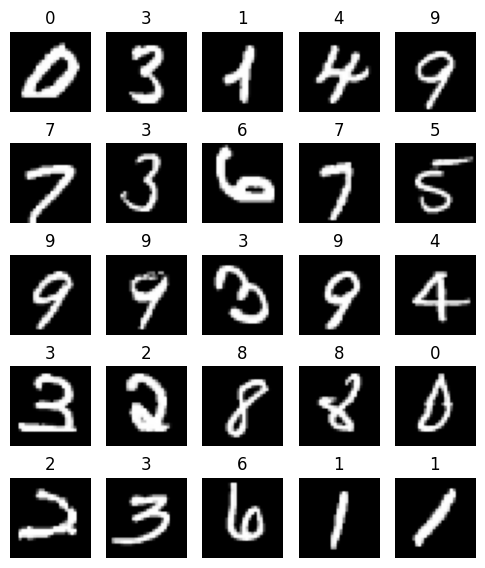

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [39]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

He инициализация для ReLU

In [40]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 250)
layer_3 = nn.Linear(250, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_3.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)
layer_3.register_backward_hook(backward_hook)

init_layer(layer_1, std=(2/784)**0.5)
init_layer(layer_2, std=(2/500)**0.5)
init_layer(layer_3, std=(2/250)**0.5)

network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2,
    nn.ReLU(),
    layer_3,
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0010619163513184
forward 0.8394426107406616
forward 0.8065458536148071
backward 0.024037005379796028
backward 0.017418861389160156
backward 0.010276873596012592


Инициализация по умолчанию с большой дисперсией, но теперь будем использовать в качестве функции активации гиперболический тангенс

In [41]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 250)
layer_3 = nn.Linear(250, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_3.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)
layer_3.register_backward_hook(backward_hook)

init_layer(layer_1, 0, 2)
init_layer(layer_2, 0, 2)
init_layer(layer_3, 0, 2)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2,
    nn.Tanh(),
    layer_3,
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0010619163513184
forward 0.9927281737327576
forward 0.9912469983100891
backward 0.024037005379796028
backward 0.024212868884205818
backward 0.06929461658000946


Вывод: Если инициализировать веса с большой дисперсией, то при прямом проходе дисперсии выходов всегда максимальны, что говорит о том, что дисперсии выходов до применения функции активации велики.

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

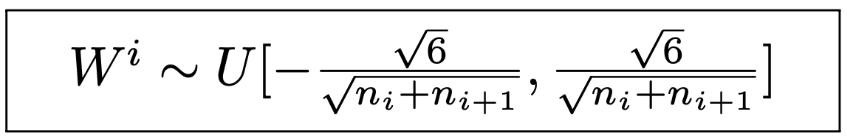

In [42]:
def init_layer(layer, left=-1, right=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(left, right)

In [43]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 250)
layer_3 = nn.Linear(250, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_3.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)
layer_3.register_backward_hook(backward_hook)

init_layer(layer_1, -(6 / (784 + 500))**0.5, (6 / (784 + 500))**0.5)
init_layer(layer_2, -(6 / (500 + 250))**0.5, (6 / (500 + 250))**0.5)
init_layer(layer_3, -(6 / (250 + 10))**0.5, (6 / (250 + 10))**0.5)

network = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2,
    nn.Tanh(),
    layer_3,
)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0010619163513184
forward 0.6555154919624329
forward 0.541837215423584
backward 0.024037005379796028
backward 0.021297721192240715
backward 0.009892161935567856


С применением инициализации Xavier дисперсия при прямом проходе перестала быть максимальной, при этом значения не сильно не отличаются, как и при обратном проходе. Xavier и He оба улучшают сходимость, благодаря сохранению дисперсии, но Xavier пользуется дифференцируемостью функции активации в нуле и зависит, как от её значения в нуле, так и от производной, так что при выборе другой функции активации (например, сигмоиды) нужно менять константу. А инициализация He разработана специально для ReLU, который не имеет производной в нуле.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

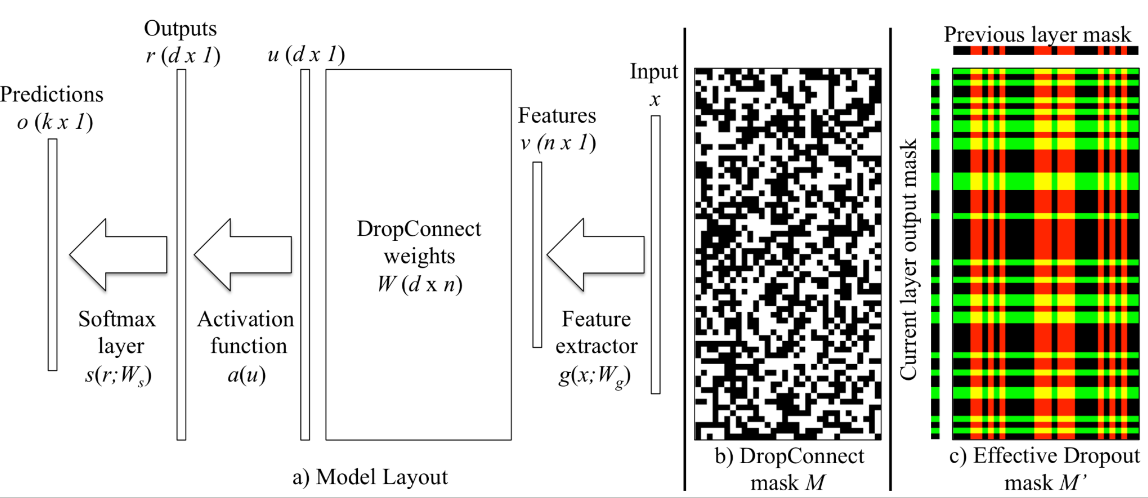

Основа для сети, которую будем обучать:

In [45]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [57]:
def train(model1, name1, model2, name2, opt1, opt2, loss_fn, n_epochs=5, plot=True, verbose=True):
    model1_train_loss_epochs = []
    model2_train_loss_epochs = []

    model1_val_loss_epochs = []
    model2_val_loss_epochs = []

    model1.train()
    model2.train()
    for epoch in range(n_epochs):
        model1_losses = []
        model2_losses = []
        # обучение
        for batch_idx, (images_train, labels_train) in enumerate(tqdm(train_loader)):
            X = images_train.data
            y = labels_train.data
            output1 = model1(X)
            output2 = model2(X)
            loss1 = loss_fn(output1, y)
            loss2 = loss_fn(output2, y)

            model1_losses.append(loss1.detach())
            model2_losses.append(loss2.detach())
            loss1.backward()
            opt1.step()
            loss2.backward()
            opt2.step()
            opt1.zero_grad()
            opt2.zero_grad()

        model1_train_loss_epochs.append(np.mean(model1_losses))
        model2_train_loss_epochs.append(np.mean(model2_losses))
        
        # валидация
        model1_losses = []
        model2_losses = []
        with torch.no_grad():
            for batch_idx,(images_test, labels_test) in enumerate(test_loader):
                output1 = model1(X)
                output2 = model2(X)
                loss1 = loss_fn(output1, y)
                loss2 = loss_fn(output2, y)
                model1_losses.append(loss1)
                model2_losses.append(loss2)
        model1_val_loss_epochs.append(np.mean(model1_losses))
        model2_val_loss_epochs.append(np.mean(model2_losses))
        
        clear_output(True)
        if verbose:
            sys.stdout.write('\rEpoch {0}... ({1} Train/Test): {2:.3f}/{3:.3f}\t({4} Train/Test): {5:.3f}/{6:.3f}'.format(
                        epoch, name1, model1_train_loss_epochs[-1], model1_val_loss_epochs[-1], name2,
                        model2_train_loss_epochs[-1], model2_val_loss_epochs[-1]))
        if plot:
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(model1_train_loss_epochs, label=name1)
            plt.plot(model2_train_loss_epochs, label=name2)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Train Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.subplot(1, 2, 2)
            plt.plot(model1_val_loss_epochs, label=name1)
            plt.plot(model2_val_loss_epochs, label=name2)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Test Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid('on')
            plt.show()



#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [51]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super(Dropout, self).__init__()
        self.p = p

    def forward(self, x):
        mask = torch.empty(x.shape).uniform_(0, 1).type(torch.FloatTensor)
        if self.training:
            mask = torch.where(mask > self.p, 1, 0)
        else:
            mask = torch.where(mask > self.p, 1, 1 - self.p)

        return x * mask

In [52]:
class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p).type(torch.FloatTensor)
        if self.eval:
            mask = torch.where(mask > 0, 1, 1 - self.p)
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

In [66]:
layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(128, 10)
]

layers_dropconnect = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

In [67]:
network_dropout = TestNetwork(nn.Sequential(*layers_dropout))
network_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer_dropout = torch.optim.Adam(network_dropout.parameters(), lr=0.001)
optimizer_dropconnect = torch.optim.Adam(network_dropconnect.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Epoch 14... (Dropout Train/Test): 0.104/0.108	(DropConnect Train/Test): 0.056/0.066

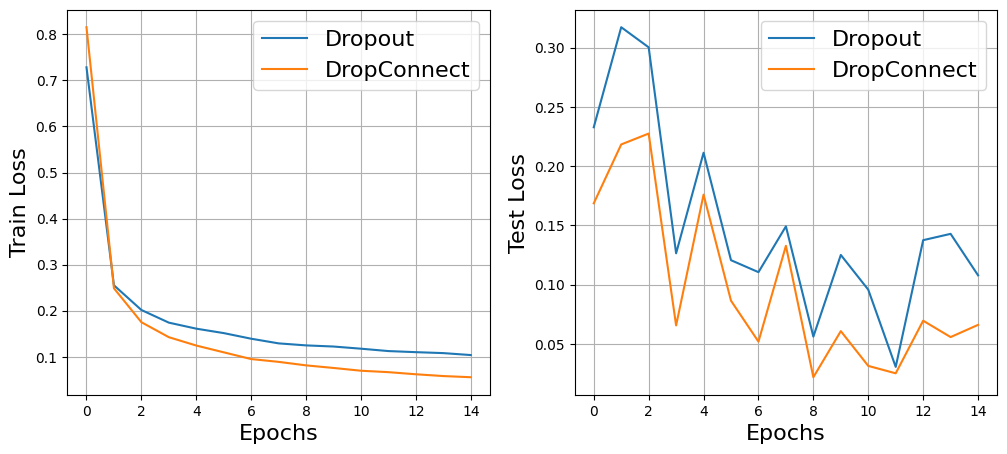

In [68]:
train(network_dropout, "Dropout", network_dropconnect, "DropConnect",
      optimizer_dropout, optimizer_dropconnect, loss_fn, n_epochs=15)

DropConnect показал себя лучше для данной задачи. 

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

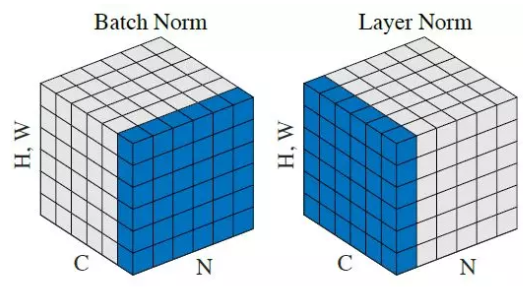

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [306]:
# полезные функции: .std(dim), .mean(dim)

class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5):
        super().__init__()
        self.num_features = num_features
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, unbiased=False, keepdim=True)
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        output = self.gamma * x_normalized + self.beta
        return output

In [299]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, momentum=0.1, eps=1e-5):
        super(BatchNorm, self).__init__()
        self.num_features = num_features
        self.momentum = momentum
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(num_features))
        self.beta = nn.Parameter(torch.zeros(num_features))
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

    def forward(self, x):
        if self.training:
            mean = x.mean(dim=0)
            var = x.var(dim=0, unbiased=False)
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * var
        else:
            mean = self.running_mean
            var = self.running_var

        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * x_normalized + self.beta
        return out


#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [341]:
layers_batch_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    BatchNorm(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    BatchNorm(128),
    nn.Linear(128, 10)
]

In [360]:
layers_layer_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNorm(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNorm(128),
    nn.Linear(128, 10)
]

In [366]:
network_batch_norm = TestNetwork(nn.Sequential(*layers_batch_norm))
network_layer_norm = TestNetwork(nn.Sequential(*layers_layer_norm))
optimizer_batch_norm = torch.optim.Adam(network_batch_norm.parameters(), lr=0.001)
optimizer_layer_norm = torch.optim.Adam(network_layer_norm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Epoch 9... (BatchNorm Train/Test): 0.028/0.014	(LayerNorm Train/Test): 0.033/0.013

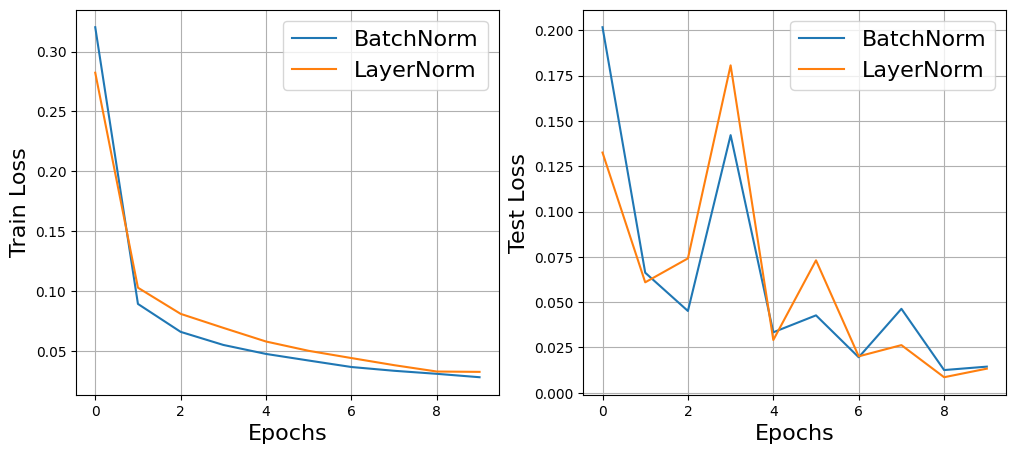

In [368]:
train(network_batch_norm, "BatchNorm", network_layer_norm, "LayerNorm",
      optimizer_batch_norm, optimizer_layer_norm, loss_fn, n_epochs=10)

In [369]:
layers_torch_batch_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Linear(128, 10)
]

layers_my_batch_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    BatchNorm(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    BatchNorm(128),
    nn.Linear(128, 10)
]

network_torch_batch_norm = TestNetwork(nn.Sequential(*layers_torch_batch_norm))
network_my_batch_norm = TestNetwork(nn.Sequential(*layers_my_batch_norm))
optimizer_torch_batch_norm = torch.optim.Adam(network_torch_batch_norm.parameters(), lr=0.001)
optimizer_my_batch_norm = torch.optim.Adam(network_my_batch_norm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Epoch 9... (Torch BatchNorm Train/Test): 0.031/0.019	(My BatchNorm Train/Test): 0.038/0.060

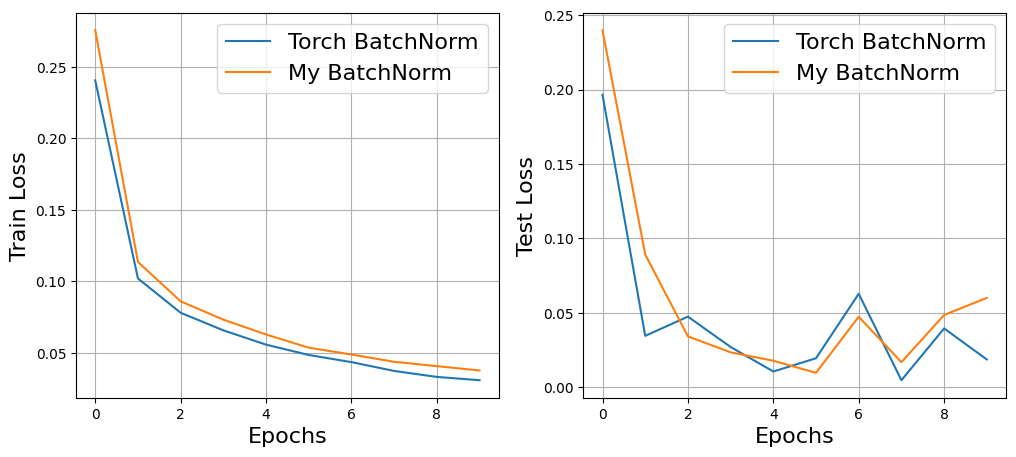

In [370]:
train(network_torch_batch_norm, "Torch BatchNorm", network_my_batch_norm, "My BatchNorm",
      optimizer_torch_batch_norm, optimizer_my_batch_norm, loss_fn, n_epochs=10)

In [63]:
layers_torch_layer_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.LayerNorm(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.LayerNorm(128),
    nn.Linear(128, 10)
]

layers_my_layer_norm = [
    nn.Linear(196, 128),
    nn.ReLU(),
    LayerNorm(128),
    nn.Linear(128, 128),
    nn.ReLU(),
    LayerNorm(128),
    nn.Linear(128, 10)
]

network_torch_layer_norm = TestNetwork(nn.Sequential(*layers_torch_layer_norm))
network_my_layer_norm = TestNetwork(nn.Sequential(*layers_my_layer_norm))
optimizer_torch_layer_norm = torch.optim.Adam(network_torch_layer_norm.parameters(), lr=0.001)
optimizer_my_layer_norm = torch.optim.Adam(network_my_layer_norm.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

NameError: name 'LayerNorm' is not defined

Epoch 9... (Torch LayerNorm Train/Test): 0.024/0.016	(My LayerNorm Train/Test): 0.022/0.026

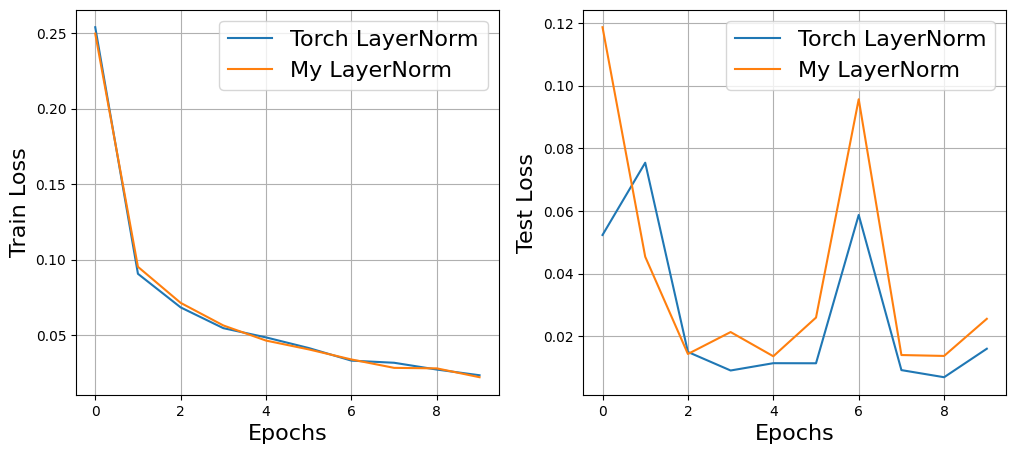

In [377]:
train(network_torch_layer_norm, "Torch LayerNorm", network_my_layer_norm, "My LayerNorm",
      optimizer_torch_layer_norm, optimizer_my_layer_norm, loss_fn, n_epochs=10)